<a name="TOC"></a>
# Dynamics Tutorial 3: TSH and mSDM. Options within NBRA.

In this tutorial we will learn:

* how to run the adiabatic calculations
* how to run the non-adiabatic calculations (FSSH)
* how to incorporate decoherence correction via mSDM
* how to run NBRA and non-NBRA calculations

Note:
  NBRA - neglect of back-reaction approximation

TOC:

1. [Define models](#define_models)
2. [Plotting](#plotting)

 2.1. [Plotting PES/properties](#pes_plot)
 
 2.2. [Plotting dynamical variables](#dyn_plot)


3. [PES scan](#pes_scan)

 3.1. [Diabatic PES scan](#pes_scan-1)
 
 3.2. [Numeric Adiabatic PES scan](#pes_scan-2)
 
 3.3. [Analytic Adiabatic PES scan](#pes_scan-3)


4. [Dynamics](#dynamics)

 4.1. [non-NBRA](#non-nbra)
 
  * [4.1.1.](#non-nbra-1) adiabatic dynamics on the ground adiabatic state  
  * [4.1.2.](#non-nbra-2) adiabatic dynamics on the excited adiabatic state     
  * [4.1.3.](#non-nbra-3) non-adiabatic dynamics on the both states via FSSH  
  * [4.1.4.](#non-nbra-4) non-adiabatic dynamics on the both states via FSSH + mSDM

 4.2. [NBRA-FSSH](#nbra-fssh)
 
  * [4.2.1.](#nbra-fssh-1) FSSH along the adiabatic dynamics on the ground state   
  * [4.2.2.](#nbra-fssh-2) FSSH along the adiabatic dynamics on the excited state     
  * [4.2.3.](#nbra-fssh-3) FSSH along the non-adiabatic dynamics trajectories obtained with FSSH  
  * [4.2.4.](#nbra-fssh-4) FSSH along the non-adiabatic dynamics trajectories obtained with FSSH + mSDM
  
  4.3. [NBRA-mSDM](#nbra-msdm)
 
  * [4.3.1.](#nbra-msdm-1) mSDM along the adiabatic dynamics on the ground state   
  * [4.3.2.](#nbra-msdm-2) mSDM along the adiabatic dynamics on the excited state     
  * [4.3.3.](#nbra-msdm-3) mSDM along the non-adiabatic dynamics trajectories obtained with FSSH  
  * [4.3.4.](#nbra-msdm-4) mSDM along the non-adiabatic dynamics trajectories obtained with FSSH + mSDM


In [1]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py.models import Tully
from libra_py.models import Holstein
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import tsh_algo1
from libra_py import dynamics
from libra_py import data_conv

import matplotlib.pyplot as plt   # plots
import numpy as np
#from matplotlib.mlab import griddata

%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

<a name="define_models"></a>
[Back to TOC](#TOC)

## 1. Define the models

First, lets defined the model Hamiltonians in the diabatic and diabatic representation. This part has been covered in the previous tutorials. 

As before, we use a 2-state spin-boson Hamiltonian, which can be written in adiabatic representation analytically. 

In [2]:
class tmp:
    pass

def my_test_dia_abstract(q, params, full_id):
    """
   
    2-state spin-boson model [Ref: Subotnik, JCP 135, 191101, 2011]

         | 0.5*m*w^2*x^2 + M*x          V                    |
    H =  |                                                   |
         |       V               0.5*m*w^2*x^2 - M*x - eps   |
         

    M = sqrt(E_r * m * w^2 / 2)
    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["omega"]** ( double ):  [ units: a.u. ]
            * **params["E_r"]**   ( double ):  [ units: Ha ]
            * **params["mass"]** ( double ):  [ units: a.u. ]
            * **params["V"]**   ( double ):  [ units: Ha ]
            * **params["epsilon"]**   ( double ):  [ units: Ha ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
 
    """


    critical_params = [] 
    default_params = { "omega":3.5e-4, "E_r":2.39e-2, "mass":1.0, "V":1.49e-5, "epsilon":1.5e-2  }
    comn.check_input(params, default_params, critical_params)

    omega = params["omega"]
    E_r = params["E_r"]
    mass = params["mass"]
    V = params["V"]
    epsilon = params["epsilon"]
    
    n = 2

    Hdia = CMATRIX(n,n)
    Sdia = CMATRIX(n,n)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(n,n) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(n,n) )
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)
    
    Sdia.identity()    
    
    M = omega * math.sqrt(0.5*E_r * mass)
    
    Hdia.set(0,0,  (0.5*mass*omega*omega*x*x + M *x )  * (1.0+0.0j) )
    Hdia.set(1,1,  (0.5*mass*omega*omega*x*x - M *x - epsilon )  * (1.0+0.0j) )
    Hdia.set(0,1,  V  * (1.0+0.0j) )
    Hdia.set(1,0,  V  * (1.0+0.0j) )
            
    d1ham_dia[0].set(0, 0, (omega*omega*x + M)*(1.0+0.0j) )    
    d1ham_dia[0].set(1, 1, (omega*omega*x - M)*(1.0+0.0j) )    
    d1ham_dia[0].set(0, 1, (0.0+0.0j) )    
    d1ham_dia[0].set(1, 0, (0.0+0.0j) )    
            
                    
    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.dc1_dia = dc1_dia

    return obj


def my_test_adi_abstract(q, params, full_id):
    """
   
    2-state spin-boson model [Ref: Subotnik, JCP 135, 191101, 2011]

         | 0.5*m*w^2*x^2 - eps/2 - sqrt( (eps/2 + M*x)^2 + V^2 )          d12 * i          |
    H =  |                                                                                 | 
         |       -d12 * i      0.5*m*w^2*x^2 - eps/2 - sqrt( (eps/2 + M*x)^2 + V^2 )       |
         

    M = sqrt(E_r * m * w^2 / 2)
    
    d12 = 0.5 * M * V / [ (eps/2 +  M*x)^2 + V^2 ]
    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["omega"]** ( double ):  [ units: a.u. ]
            * **params["E_r"]**   ( double ):  [ units: Ha ]
            * **params["mass"]** ( double ):  [ units: a.u. ]
            * **params["V"]**   ( double ):  [ units: Ha ]
            * **params["epsilon"]**   ( double ):  [ units: Ha ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
    """


    critical_params = [] 
    default_params = { "omega":3.5e-4, "E_r":2.39e-2, "mass":1.0, "V":1.49e-5, "epsilon":1.5e-2  }
    comn.check_input(params, default_params, critical_params)

    omega = params["omega"]
    E_r = params["E_r"]
    mass = params["mass"]
    V = params["V"]
    epsilon = params["epsilon"]
    
    n = 2

    Hadi = CMATRIX(n,n)
    d1ham_adi = CMATRIXList();  d1ham_adi.append( CMATRIX(n,n) )
    dc1_adi = CMATRIXList();  dc1_adi.append( CMATRIX(n,n) )
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)

    
    M = omega * math.sqrt(0.5*E_r * mass)
    
    t = (epsilon/2.0 +  M*x)**2 + V * V 
    tsq = math.sqrt(t)
    dtsq = M * (epsilon/2.0 + M*x)/tsq   # d [tsq]/dx
    d = 0.5*M*V/t
        
    
    Hadi.set(0,0,  (0.5*mass*omega*omega*x*x - 0.5*epsilon - tsq) * (1.0+0.0j) )
    Hadi.set(1,1,  (0.5*mass*omega*omega*x*x - 0.5*epsilon + tsq) * (1.0+0.0j) )
    Hadi.set(0,1,  (0.0+0.0j) )
    Hadi.set(1,0,  (0.0+0.0j) )
            
    d1ham_adi[0].set(0, 0, (omega*omega*x - dtsq )*(1.0+0.0j) )    
    d1ham_adi[0].set(1, 1, (omega*omega*x + dtsq )*(1.0+0.0j) )    
    d1ham_adi[0].set(0, 1, (0.0+0.0j) )    
    d1ham_adi[0].set(1, 0, (0.0+0.0j) )    
    
    dc1_adi[0].set(0, 1, d*(1.0+0.0j) )    
    dc1_adi[0].set(1, 0, d*(-1.0+0.0j) )    
    dc1_adi[0].set(0, 0, (0.0+0.0j) )    
    dc1_adi[0].set(1, 1, (0.0+0.0j) )    
            
                    
    obj = tmp()
    obj.ham_adi = Hadi    
    obj.d1ham_adi = d1ham_adi
    obj.dc1_adi = dc1_adi

    return obj




In addition, in this tutorial we define yet another version of the Hamiltonian setup function **my_test_adi_files** which really just reads the existing files (with vibronic Hamiltonians) and returns the object that contains the **hvib_adi** member with such matrices. This function is meant to be used with the NBRA-type calculations, when the (vibronic) Hamiltonians are already pre-computed for the entire trajectories and do not affect the nuclear dynamics. This is why we don't really need anything other than the vibronic Hamiltonians. 

Unlike in the previous setups, the **params** variable is now expected to contain two keys:

* **prefix** - indicates the common part of the files to read (e.g. including the path to those files). The files should contain the vibronic Hamiltonian matrices in a particular format. The format can be changed together with the corresponding code to read it in. 

* **timestep** - the index of the filename to read. This index should correspond to the integration timestep. This parameter is changed in the **dynamics.run_dynamics** function before the call of this Hamiltonian evaluation is made. This way, one can read the files for particular timesteps.

The format of the files to read is expected to be "{prefix}{indx}.txt", so it could be that we'd read the files named:
"res/Ham_0.txt", "res/Ham_1.txt", "res/Ham_2.txt", ... "res/Ham_1000.txt" 



In [3]:
def my_test_adi_files(q, params, full_id):
    """
   
    Read in the vibronic Hamiltonians along the trajectories
    
    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1, but they do not really affect anything
        params ( dictionary ): model parameters

            * **params["timestep"]** ( int ):  [ index of the file to read ]
            * **params["prefix"]**   ( string ):  [ the prefix of the file to read ]
        

    Returns:       
        PyObject: obj, with the members:

            * obj.hvib_adi ( CMATRIX(n,n) ): adiabatic vibronic Hamiltonian 
            
    """
    
    n = 2

    H_vib_adi = CMATRIX(n,n)    
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]    
    timestep = params["timestep"]
    prefix = params["prefix"]
        
    f = open(F"{prefix}{indx}.txt", "r")
    A = f.readlines()
    f.close()
    
    h = A[timestep].split()    
    
    for a in range(n):
        for b in range(n):
            re = float(h[1 + (a*n+b)*2+0])
            im = float(h[1 + (a*n+b)*2+1])
            
            H_vib_adi.set(a, b, re+im*1j)
    
                                    
    obj = tmp()
    obj.hvib_adi = H_vib_adi    
    

    return obj

The call of the file-based Hamiltonian "calculation" function will be made when we select the **model**  parameter to take the value of 3

In [4]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:
        res = my_test_dia_abstract(q, params, full_id)
    elif model==2:
        res = my_test_adi_abstract(q, params, full_id)
    elif model==3: 
        res = my_test_adi_files(q, params, full_id)        

    return res


<a name="plotting"></a>
[Back to TOC](#TOC)

## 2. Plotting functions


<a name="pes_plot"></a>
[Back to TOC](#TOC)
### 2.1. Plotting PES/properties

In [5]:
def plot_properties(grid, comp_model, model_params, dyn_params):

    ndia, nadi, ndof = 2, 2, 1
    
    rep_tdse = dyn_params["rep_tdse"]  # what we want

    # ======= Hierarchy of Hamiltonians =======
    tol = 0.01
    ham = nHamiltonian(ndia, nadi, ndof)
    ham.init_all(2)
    ham.phase_corr_ovlp_tol = tol

    ham1 = [] 
    for tr in range(1):
        ham1.append( nHamiltonian(ndia, nadi, ndof) )        
        ham1[tr].init_all(2)
        ham1[tr].phase_corr_ovlp_tol = tol
        ham.add_child(ham1[tr])
        
    

    # Energies, forces, and couplings    
    H00, H11, H01 = [], [], []
    dH00, dH11, dH01 = [], [], []
    d01 = []
    
    nsteps = len(grid)
    
    tid = Py2Cpp_int([0, 0])
    
    for i in range(nsteps):
        q = MATRIX(1,1); q.set(0, 0, grid[i])
    
        update_Hamiltonian_q(dyn_params, q, ham, compute_model, model_params)
        
        if rep_tdse==0:    
            H00.append(ham.get_ham_dia(tid).get(0,0).real)
            H11.append(ham.get_ham_dia(tid).get(1,1).real)
            H01.append(ham.get_ham_dia(tid).get(0,1).real)    
    
            
            dH00.append(ham.get_d1ham_dia(0,tid).get(0,0).real)
            dH11.append(ham.get_d1ham_dia(0,tid).get(1,1).real)            
            dH01.append(ham.get_d1ham_dia(0,tid).get(0,1).real) 
            
            d01.append(ham.get_dc1_dia(0,tid).get(0,1).real)
            
        elif rep_tdse==1:    
            H00.append(ham.get_ham_adi(tid).get(0,0).real)
            H11.append(ham.get_ham_adi(tid).get(1,1).real)
            H01.append(ham.get_ham_adi(tid).get(0,1).real)    
    
            dH00.append(ham.get_d1ham_adi(0,tid).get(0,0).real)
            dH11.append(ham.get_d1ham_adi(0,tid).get(1,1).real)            
            dH01.append(ham.get_d1ham_adi(0,tid).get(0,1).real) 
            
            d01.append(ham.get_dc1_adi(0,tid).get(0,1).real)            
            
            
    #======== Now lets plot what we have computed ===========
    plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(1,3,1)
    plt.title('Energies and couplings')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(grid, H00, label='H00', linewidth=2, color = colors["11"]) 
    plt.plot(grid, H11, label='H11', linewidth=2, color = colors["21"]) 
    plt.plot(grid, H01, label='H01', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(1,3,2)
    plt.title('Derivatives')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u./Bohr')
    plt.plot(grid, dH00, label='dH00', linewidth=2, color = colors["11"]) 
    plt.plot(grid, dH11, label='dH11', linewidth=2, color = colors["21"]) 
    plt.plot(grid, dH01, label='dH01', linewidth=2, color = colors["31"]) 
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.title('Derivative couplings')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u./Bohr')
    plt.plot(grid, d01, label='d01', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.show()
    plt.close()

<a name="dyn_plot"></a>
[Back to TOC](#TOC)

### 2.2. Plotting the results of dynamical calculations

In [6]:
def plot_dyn(res):
    # Format: 
    #   0      1      2       3        4        5           6          7        8            9       10        11            12        13       14         15             16          17
    #obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop  obs_states obs_hvib_adi obs_hvib_dia  obs_St

    obs_T = res[0]
    obs_Ekin = res[3]
    obs_Epot = res[4]
    obs_Etot = res[5]
    obs_dEkin = res[6]
    obs_dEpot = res[7]
    obs_dEtot = res[8]
    obs_dm_adi00 = data_conv.unpack1(res[11], 0, 0, 0)
    obs_dm_adi11 = data_conv.unpack1(res[11], 1, 1, 0)
    obs_dm_dia00 = data_conv.unpack1(res[12], 0, 0, 0)
    obs_dm_dia11 = data_conv.unpack1(res[12], 1, 1, 0)
    obs_pop00 = data_conv.unpack1(res[13], 0, 0, 2)
    obs_pop11 = data_conv.unpack1(res[13], 1, 0, 2)
    obs_q = data_conv.unpack1(res[1], 0, 0, 2)
    obs_p = data_conv.unpack1(res[2], 0, 0, 2)
    
    ndof = res[1][0].num_of_rows
    ntraj = res[1][0].num_of_cols
    

    plt.figure(1, figsize=(24, 24)) # dpi=300, frameon=False)

    plt.subplot(3,2,1)
    plt.title('q-t')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Coordiante, a.u.')
    
    for tr in range(ntraj):
        obs_q = data_conv.unpack1(res[1], 0, tr, 2)
        plt.plot(obs_T, obs_q, label="", linewidth=2, color = colors["11"])   # label='q vs. t'
    plt.legend()

    plt.subplot(3,2,2)
    plt.title('Phase portrait')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Momentum, a.u.')    
    for tr in range(ntraj):
        obs_q = data_conv.unpack1(res[1], 0, tr, 2)
        obs_p = data_conv.unpack1(res[2], 0, tr, 2)
        plt.plot(obs_q, obs_p, linewidth=2, color = colors["11"])  # label='p vs. q'
    plt.legend()

    plt.subplot(3,2,3)
    plt.title('Adiabatic populations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population of state 0')
    plt.plot(obs_T, obs_pop00, "--o", label='SH P(0)', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dm_adi00, "--o", label='SE P(0)', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_pop11, "--", label='SH P(1)', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dm_adi11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.subplot(3,2,4)
    plt.title('Diabatic populations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population of state 0')
    plt.plot(obs_T, obs_dm_dia00, label='SE P(0)', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_dm_dia11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.subplot(3,2,5)
    plt.title('Energies')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(obs_T, obs_Ekin, label='Ekin', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_Epot, label='Epot', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_Etot, label='Etot', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(3,2,6)
    plt.title('Energy fluctuations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(obs_T, obs_dEkin, label='dEkin', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dEpot, label='dEpot', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_dEtot, label='dEtot', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.show()
    plt.close()

<a name="pes_scan"></a>
[Back to TOC](#TOC)

## 3. PES scan

Define the grid

In [7]:
xmin = -500.0
xmax = 300.0
dx = 1.0

X = []
nsteps = int((xmax - xmin) / dx) + 1

for i in range(nsteps):
    X.append(xmin + i * dx)

Now, let plot the PES in 3 ways:

<a name="pes_scan-1"></a>
[Back to TOC](#TOC)

### 3.1. Option 1: Diabatic properties

We want diabatic properties and the model Hamiltonian does return the diabatic properties

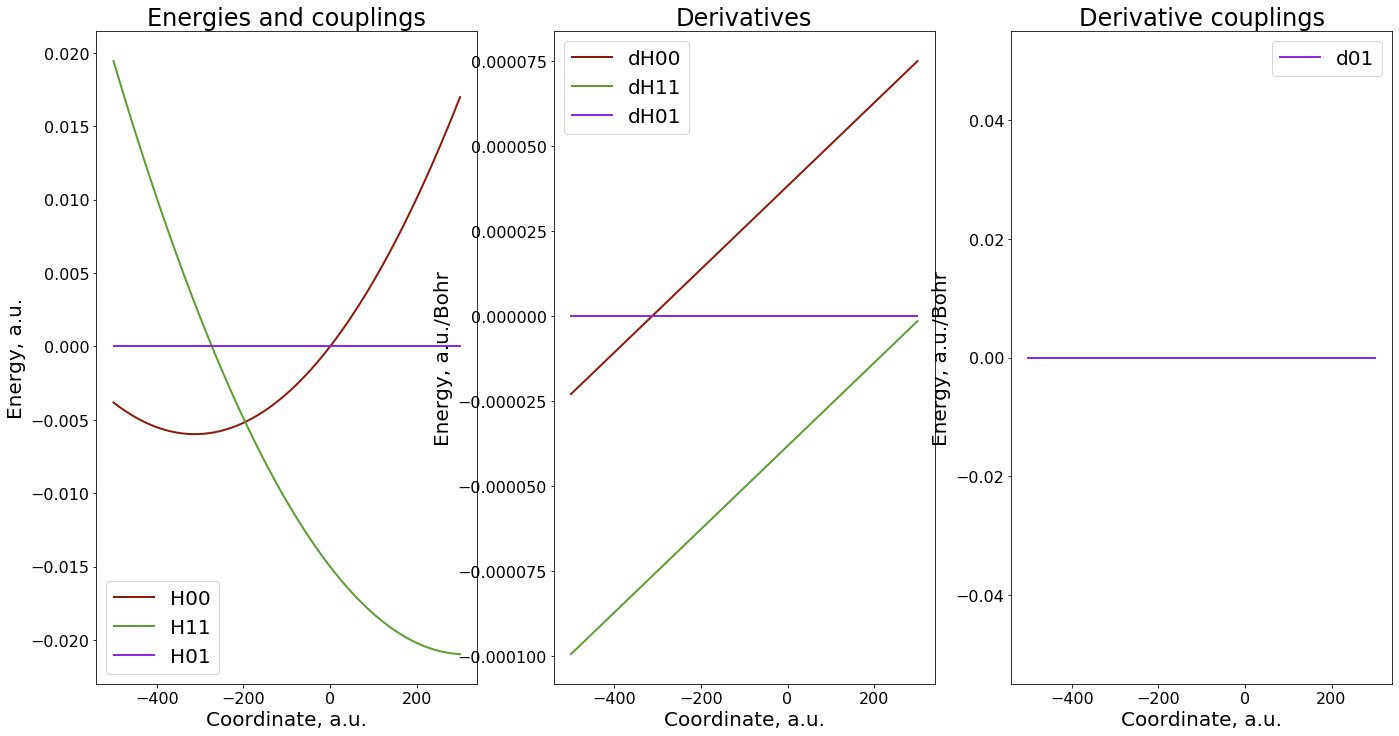

In [8]:
plot_properties(X, compute_model, {"model":1}, {"rep_tdse":0, "rep_ham":0} )

<a name="pes_scan-2"></a>
[Back to TOC](#TOC)

### 3.2. Option 2: Adiabatic properties via numerical adiabatization
Now, we want adiabatic properties but the model returns only the diabatic properties, so the needed calculations will be done under the hood

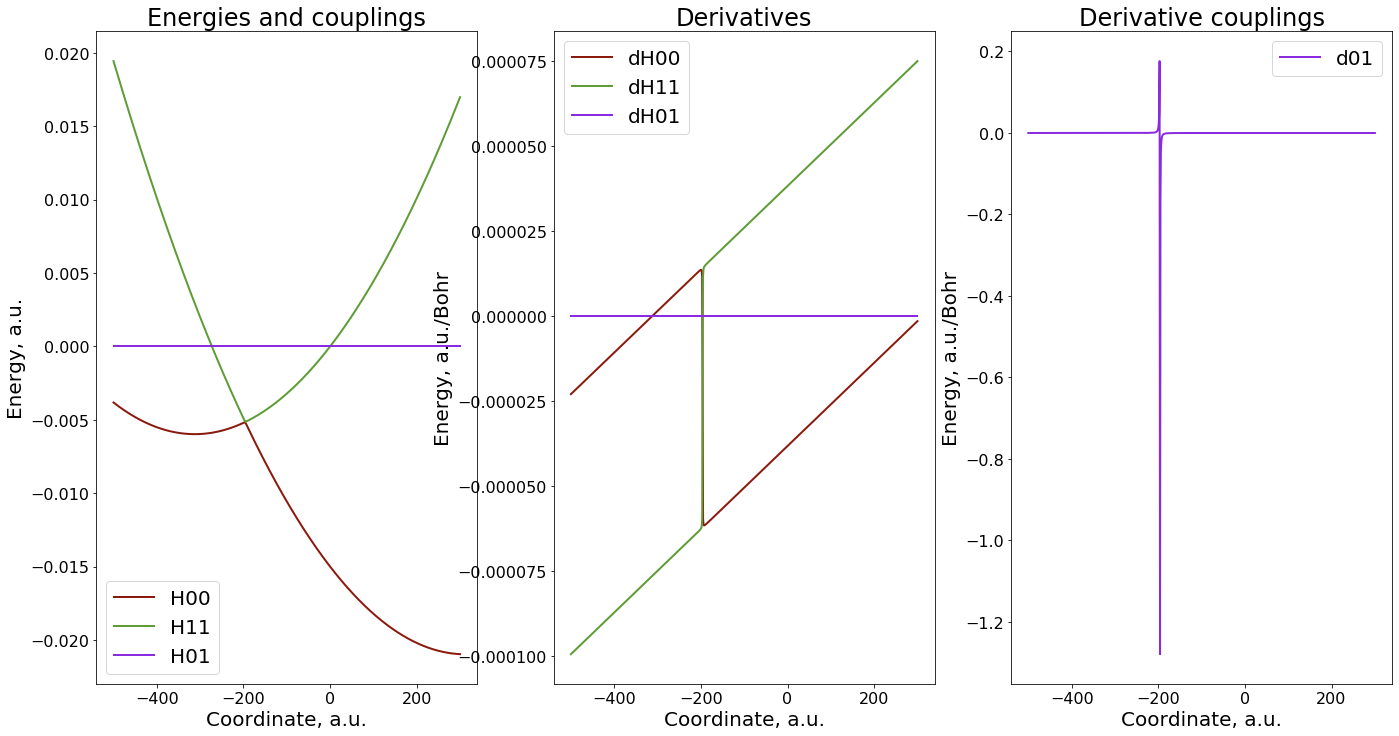

In [9]:
plot_properties(X, compute_model, {"model":1}, {"rep_tdse":1, "rep_ham":0} )

<a name="pes_scan-3"></a>
[Back to TOC](#TOC)

### 3.3. Option 3: Analytic Adiabatic properties

Finally, we want adiabatic properties - and out Hamiltonian already returns them via analytical expression - so no additional diaginalization is dune.

Note, how we also requested another model to be called in the model_parameters (third argument).

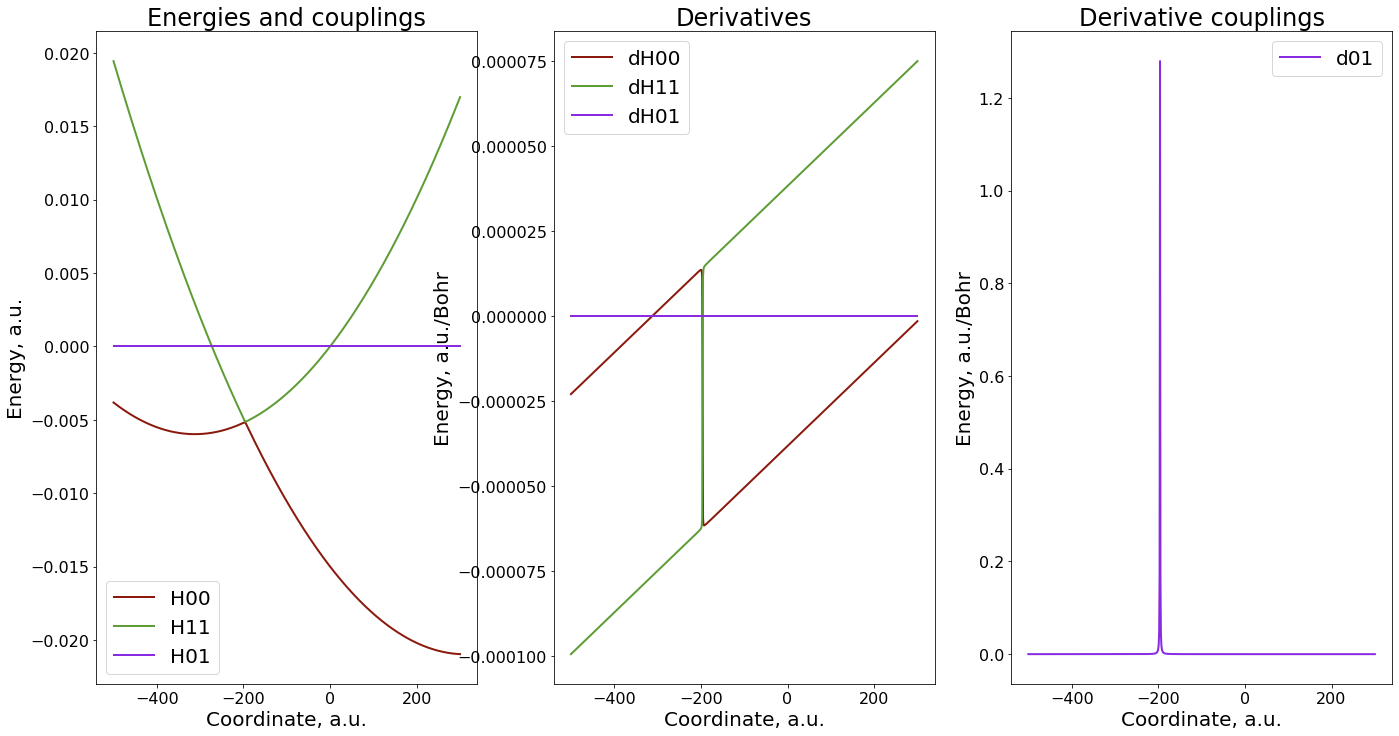

In [10]:
plot_properties(X, compute_model, {"model":2}, {"rep_tdse":1, "rep_ham":1} )

<a name="dynamics"></a>
[Back to TOC](#TOC)

## 4. Dynamics

Before, we run the calculations, we need to initialize our dynmaical variables - both electronic and nuclear. 

The nuclear initial conditions for all the runs below will be identical, so we can set them up here.

In this test, we consider just 25 trajectories: (``ntraj = 25``)

The initial coordinates and momenta of each trajectory will be drawn from the normal distribution with the center values for coordinate to be -300.0 and momenta to be 20.0. This type of initialization is defined by ``"init_type":3`` key-value pair in the ``init_nucl`` variable. The centers of the distributions are given as the values of the two first arguments (lists) to the **init_nuclear_dyn_var** function. Since we work with a 1D problem, each list contains only 1 element (the number of the elements should be equal to the dimensionality of the problem we consider). 

The masses (in a.u.) of nuclear DOFs are given in the 3-rd argument to **init_nuclear_dyn_var** function. 


In [11]:
# Random numbers generator object
rnd = Random()

ntraj = 25

# Initialize nuclear variables
init_nucl = {"init_type":3, "force_constant":[0.001], "ntraj":ntraj}
q, p, iM = dynamics.init_nuclear_dyn_var([-300.0], [20.0], [10.0], init_nucl, rnd)

Now, lets define the variables governing the dynamics. Most of them coorrespond to the default values (so could have been omitted in this explicit definition). However, it is convenient to have them visible/explicitly defined here.

In [12]:
dyn_params = { "rep_tdse":1, "rep_ham":0, "rep_sh":1, "rep_lz":0, "tsh_method":-1,
               "force_method":1, "nac_update_method":1, "rep_force":1,
               "use_boltz_factor":0, "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":-1,
               "do_phase_correction":0, "tol":1e-3,
               "state_tracking_algo":0, "MK_alpha":0.0, "MK_verbosity":0, 
               "entanglement_opt":0, "ETHD3_alpha":0.0, "ETHD3_beta":0.0, 
               "dt":0.1*units.fs2au, "nsteps":500, 
               "output_level":2, "file_output_level":0
              }

Some brief explanation of what they mean:

* ``"rep_tdse": 1`` - the TD-SE will be integrated in the adiabatic representation, meaning the wavefunction is assumed to be represented in the adiabatic basis and in terms of the corresponding (adiabatic rep.) amplitudes

* ``"rep_ham": 0`` - the model Hamiltonian is defined in terms of diabatic properties

* ``"rep_sh":1`` - surface hopping is done in adiabatic representation. This means, for instance, that the hopping probabilities are computed using the amplitudes of the adiabatic basis states and the vibronic Hamiltonian expressed in terms of adiabatic representation

* ``"rep_lz":0`` - not really used in these calculations

* ``"tsh_method":-1`` - how to handle surface hopping, this option (-1) implies no hopping, that is the evolution on the adiabatic PES

* ``"force_method":1`` - how to compute forces acting on the nuclei. This option (1) implies just the adiabatic forces of the active states - as prescribed by the TSH algorithms. Note that if it is used in conjunctions with the "tsh_method":-1, one gets a state-specific adiabatic dynamics.

* ``"nac_update_method":1`` - how to update the NACs used in the calculations of the vibronic Hamiltonians. This option (1) calls for its explicit evaluation using derivative coupling vectors and nuclear momenta. In the NBRA cases, it is set to (0), which means that this property is not re-computed. This re-computation is not really needed since the vibronic Hamiltonians are already passed to the nHamiltonian object via the read files.

* ``"rep_force":1`` - what types of properties are used to compute the nuclear forces. In this case (1), the adiabatic properties (derivative couplings and derivatives of the adiabatic energies) will be used. 

* ``"use_boltz_factor":0`` - scale the hopping probabilities for the transitions up in energy by the Boltzmann factor - this should be used in lieu of velocity rescaling in the non-NBRA version of the NA-MD. **WARNING: At this point, this option is not yet implemented, so we set it to 0 so far** 

* ``"Temperature":300`` - the assumed nuclear temperature (of the bath), used only if  "use_boltz_factor":1

* ``"do_reverse":1`` - instructs the algorithm to reverse the nuclear momenta along the direction of the derivative coupling if the proposed surface hops are not accepted (frustrated hops)

* ``"vel_rescale_opt":-1`` - how to rescale velocities of nuclei after sucessfull hops. The current option (-1) turns of the velocity rescaling at all (which is what you'd do in the NBRA case)

* ``"do_phase_correction":0`` -The option of "1" turns on the correction of the phase factors of adiabatic basis states. This has been shown to give a substantial effect on population transfer dynamics and should be included if possible. This phase correction is not needed if the dynamics is computed in the diabatic basis. 
**For simplicity, in this tutorial, we disregard the phase correction, so do_phase_correction = 0**

* ``"tol":1e-3`` - the minimal value of the time-overlaps <psi_i(t)|psi_j(t+dt)> when the phase correction is applied. If the time-overlap of these functions is smaller this threshold, the phase correction should not really matter, since the NACs will be small anyways, but this helps avoiding divizion by zero when the time-overlap is too small.

* ``"state_tracking_aglo":2`` - this option selects to track the identity of adiabatic states via the Munkres-Kuhn (so-called, mincost) algorithm.
**For simplicity, in this tutorial, we disregard the state tracking, so state_tracking_algo = 0**

* ``"MK_alpha":0.0`` - the parameter that controls the width of the states set which will be included in the state tracking algorithm. This value essentially selects all the states present

* ``"MK_verbosity":0`` - turns off the additional (debug) printing of the mincost algorithm processing

* ``"entanglement_opt":0`` - don't include any quantum nuclei correction on the nuclear dynamics. **WARNINIG: none of them are yet avaialble at the present point**

* ``"ETHD3_alpha"`` and ``"ETHD3_beta"`` - are meaningless at this point, just forget for now

* ``"dt"`` - integration timestep (in a.u. of time) - the same for electronic and nuclear dynamics

* ``"nsteps"`` - how many steps of the dynamics to conduct

* ``"output_level"`` - how much of the computed info to store in the returned object - this is limited by the RAM. The option 2 selects to return up to "2-dimensional" information - e.g. trajectory-resolved nuclear dynamics, aamplitudes, and state indices, but not trajectory-resolved 2-dimensional matrices

* ``"file_output_level"`` - selects how much of the computed dynamical info to store on the disc. This is limited by the disk space capacity and the time (the file I/O is usually quite slow!). Set this parameter to 3 to print out all the needed info for the NBRA-type calculations. 



<a name="non-nbra"></a>
[Back to TOC](#TOC)

### 4.1. Non-NBRA dynamics

These runs are the most "rigorous" type - they follow the Tully's prescription as close as possible, but require all the expensive properties such as excited-states gradients and derivative couplings.

In these calculations, some of the default variables will be redefined as:

* ``"istates":[0.0, 1.0]``, ``"rep":1`` - start in the first excited adiabatic state


* ``"rep_ham":0`` - model in diabatic representation
* ``"force_method":1`` - TSH forces
* ``"rep_force":1`` - compute forces via adiabatic properties
* ``"rep_tsde":1`` - solve TD-SE via propagating adiabatic amplitudes
* ``"nac_update_method":1`` - NACs via derivative couplings and nuclear momenta
* ``"tsh_method":0`` - FSSH
* ``"vel_rescale_opt":0`` - rescale velocities according to derivative coupling vector

In addition, in these calculations we set ``"file_output_level":3`` so that we produce the vibronic Hamiltonians along the computed trajectories

* ``"output_level":2`` - for immediate plotting of the results
* ``"prefix"`` - setup according to run


Note that in all following calls we pass only a copy of the ``dyn_params`` dictionary

``_dyn_params = dict(dyn_params)``

This way, we don't accidentally re-use the control variables from a previous run, and we can use the *update()* function to modify the copies of the original ``dyn_params`` variable as needed.

<a name="non-nbra-1"></a>
[Back to TOC](#TOC)


### 4.1.1. Adiabatic dynamics in the ground state.

* ``"states":[1.0, 0.0]``, ``"rep":1`` - initialize all the trajectories on the ground adiabatic state
* ``"tsh_method":-1`` - don't do surface hopping
* ``"vel_rescale_opt":-1`` - don't rescale velocities


No handles with labels found to put in legend.
No handles with labels found to put in legend.


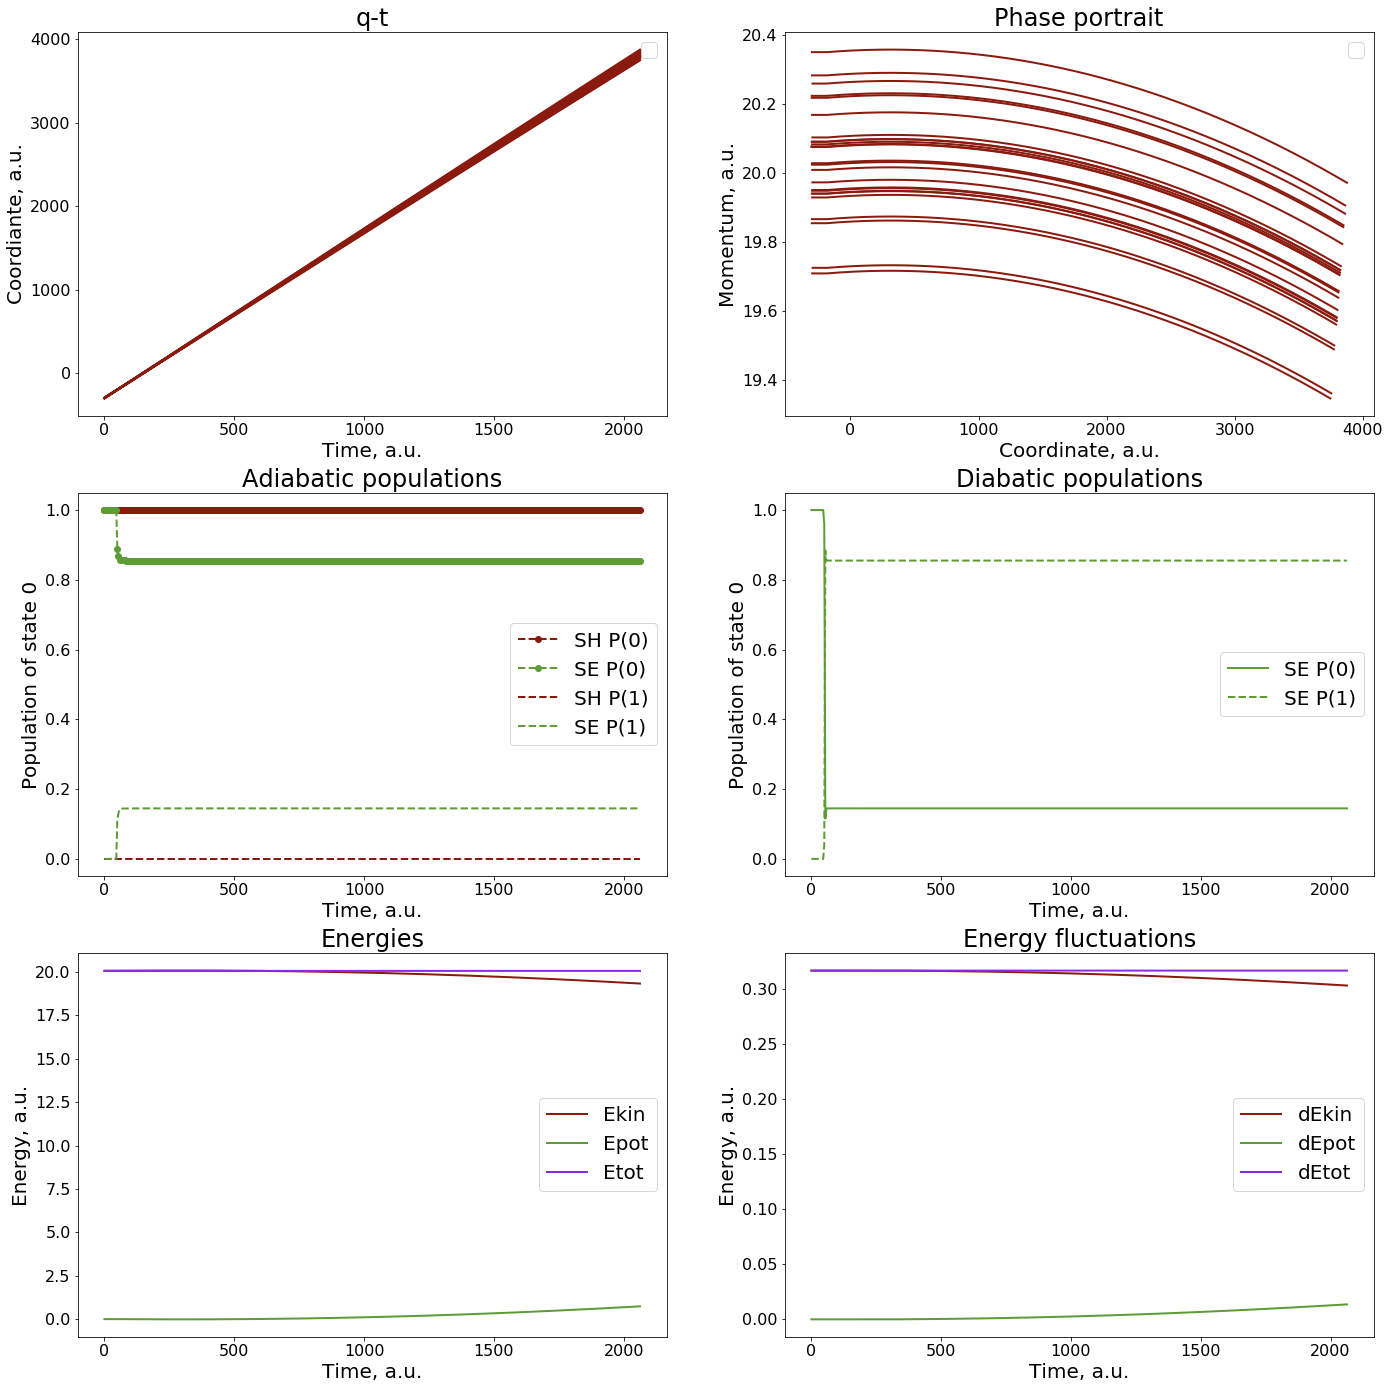

In [13]:
_init_elec = { "init_type":3, "nstates":2, "istates":[1.0, 0.0], "rep":1,  "ntraj":ntraj   }

_dyn_params = dict(dyn_params)    
_dyn_params.update({"rep_ham":0, "force_method":1, "rep_force":1, "rep_tdse":1, 
                    "nac_update_method":1, "tsh_method":-1, "vel_rescale_opt":-1})
_dyn_params.update({"prefix":"T3-1-1", "output_level":2, "file_output_level":3})

_model_params = {"model":1, "model0":1}    
res = dynamics.generic_recipe(q, p, iM, _dyn_params, compute_model, _model_params, _init_elec, rnd)
plot_dyn(res)

<a name="non-nbra-2"></a>
[Back to TOC](#TOC)


### 4.1.2. Adiabatic dynamics in the excited state.

* ``"states":[0.0, 1.0]``, ``"rep":1`` - initialize all the trajectories on the first excited adiabatic state
* ``"tsh_method":-1`` - don't do surface hopping
* ``"vel_rescale_opt":-1`` - don't rescale velocities


No handles with labels found to put in legend.
No handles with labels found to put in legend.


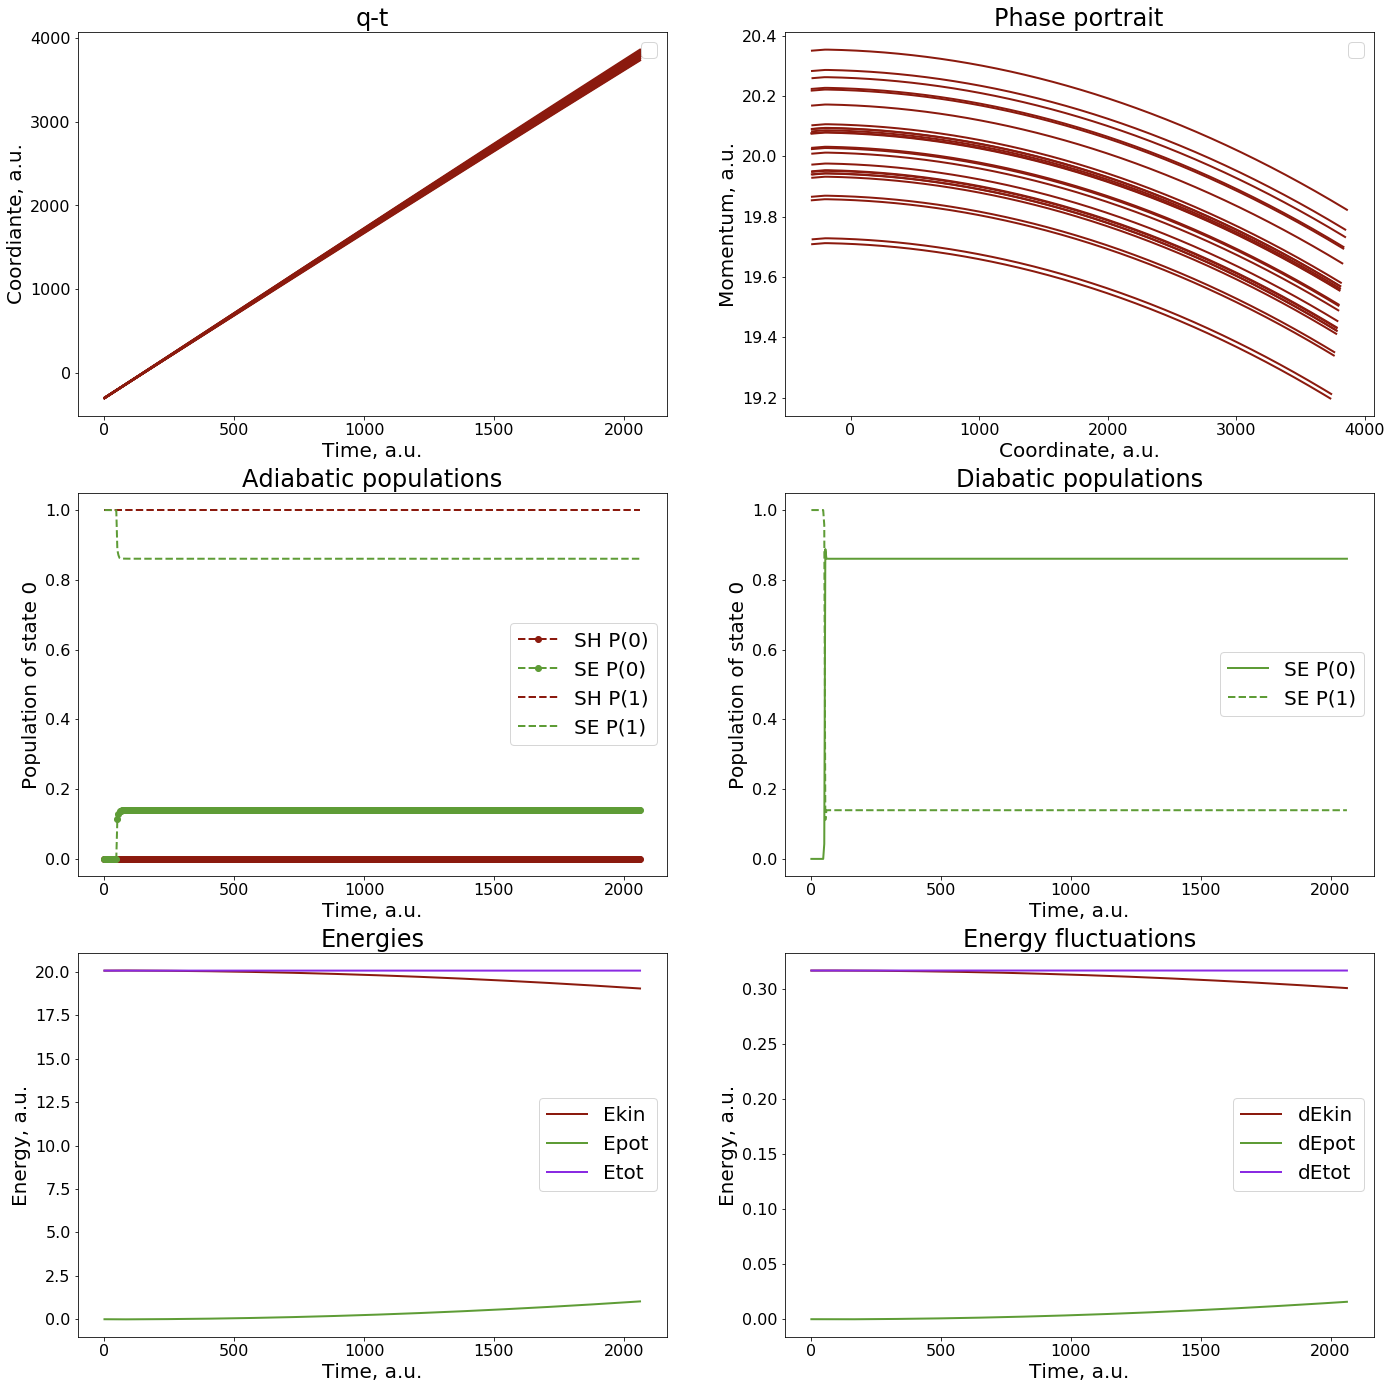

In [14]:
_init_elec = { "init_type":3, "nstates":2, "istates":[0.0, 1.0], "rep":1,  "ntraj":ntraj   }

_dyn_params = dict(dyn_params)    
_dyn_params.update({"rep_ham":0, "force_method":1, "rep_force":1, "rep_tdse":1, 
                    "nac_update_method":1, "tsh_method":-1, "vel_rescale_opt":-1})
_dyn_params.update({"prefix":"T3-1-2", "output_level":2, "file_output_level":3})
    
_model_params = {"model":1, "model0":1}    
res = dynamics.generic_recipe(q, p, iM, _dyn_params, compute_model, _model_params, _init_elec, rnd)
plot_dyn(res)

<a name="non-nbra-3"></a>
[Back to TOC](#TOC)


### 4.1.3.   FSSH in non-NBRA


* ``"states":[0.0, 1.0]``, ``"rep":1`` - initialize all the trajectories on the first excited adiabatic state
* ``"tsh_method":0`` - do the surface hopping via FSSH
* ``"vel_rescale_opt":0`` - do the velocity rescaling along derivative couplings

No handles with labels found to put in legend.
No handles with labels found to put in legend.


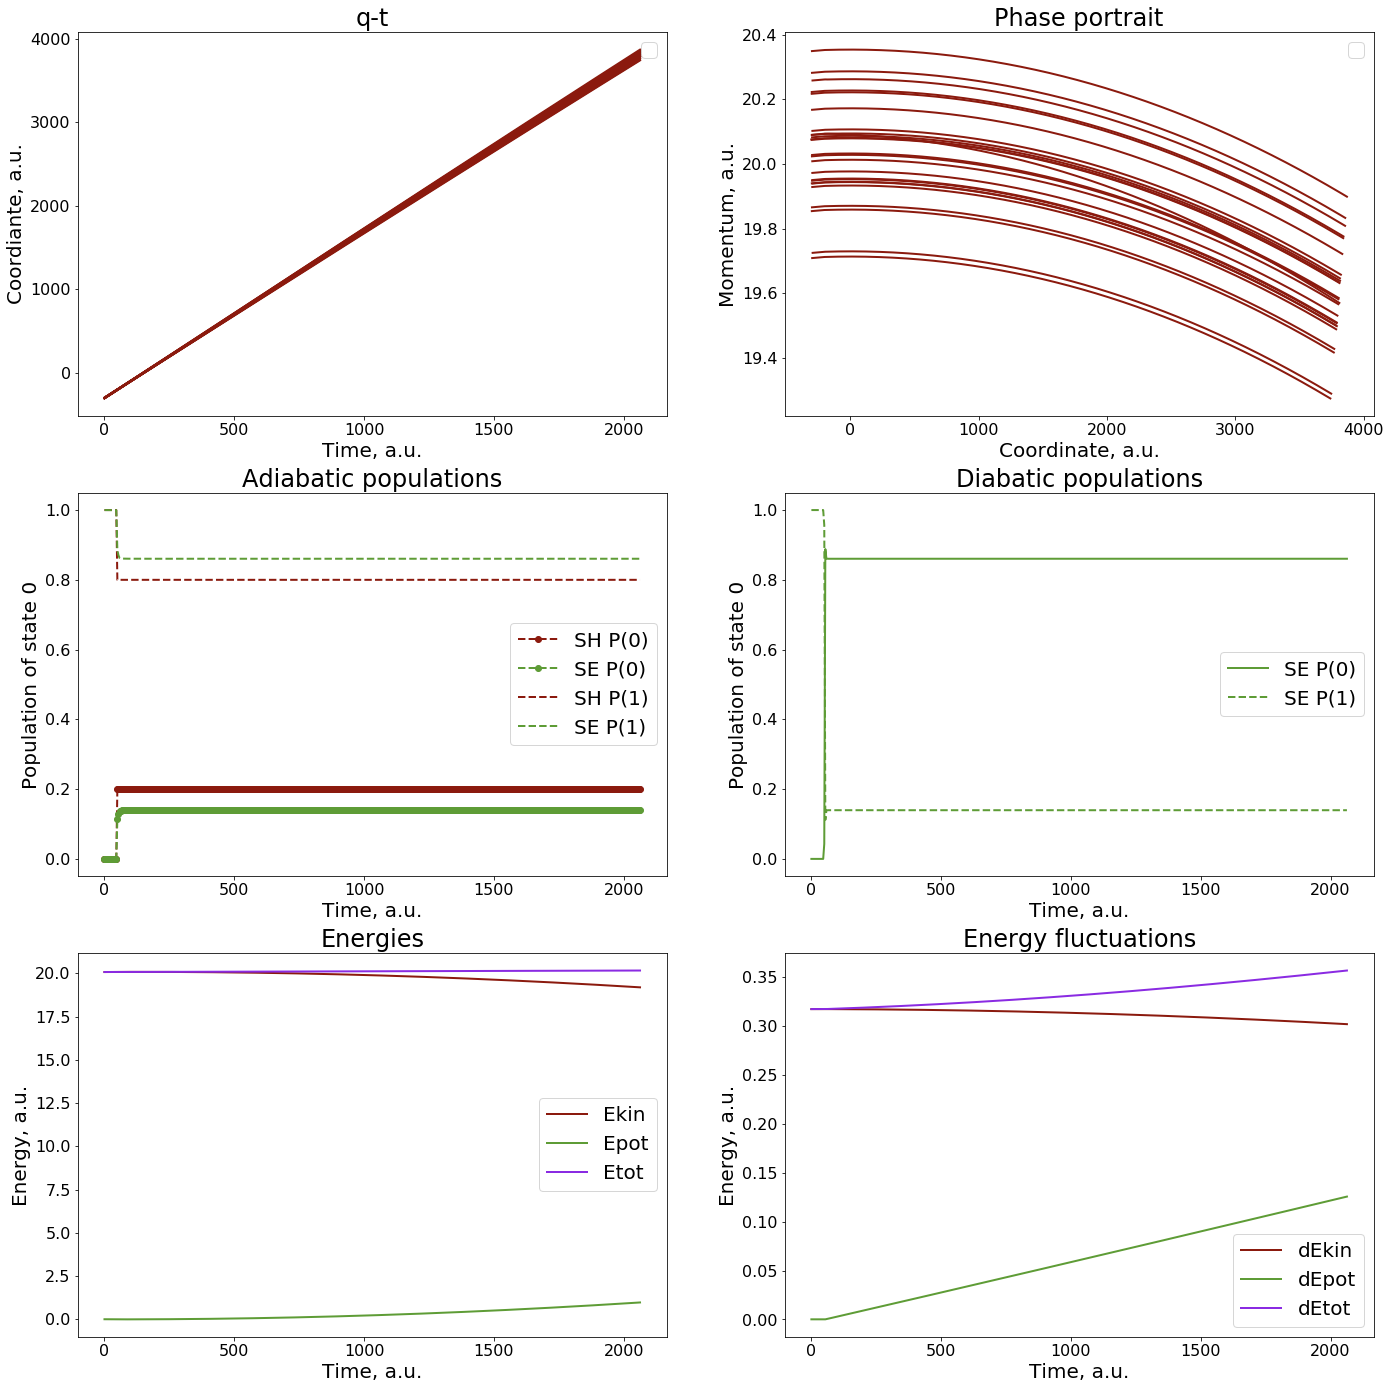

In [15]:
_init_elec = { "init_type":3, "nstates":2, "istates":[0.0, 1.0], "rep":1,  "ntraj":ntraj   }

_dyn_params = dict(dyn_params)    
_dyn_params.update({"rep_ham":0, "force_method":1, "rep_force":1, "rep_tdse":1, 
                    "nac_update_method":1, "tsh_method":0, "vel_rescale_opt":0})
_dyn_params.update({"prefix":"T3-1-3", "output_level":2, "file_output_level":3})
    
_model_params = {"model":1, "model0":1}    
res = dynamics.generic_recipe(q, p, iM, _dyn_params, compute_model, _model_params, _init_elec, rnd)
plot_dyn(res)

<a name="non-nbra-4"></a>
[Back to TOC](#TOC)


### 4.1.4.   FSSH + mSDM in non-NBRA


* ``"states":[0.0, 1.0]``, ``"rep":1`` - initialize all the trajectories on the first excited adiabatic state
* ``"tsh_method":0`` - do the surface hopping via FSSH
* ``"vel_rescale_opt":0`` - do the velocity rescaling along derivative couplings
* ``"decoherence_algo":0`` - decoherence via mSDM
* ``"decoh_rates":DM`` - a manual definition of the decoherence rates

No handles with labels found to put in legend.
No handles with labels found to put in legend.


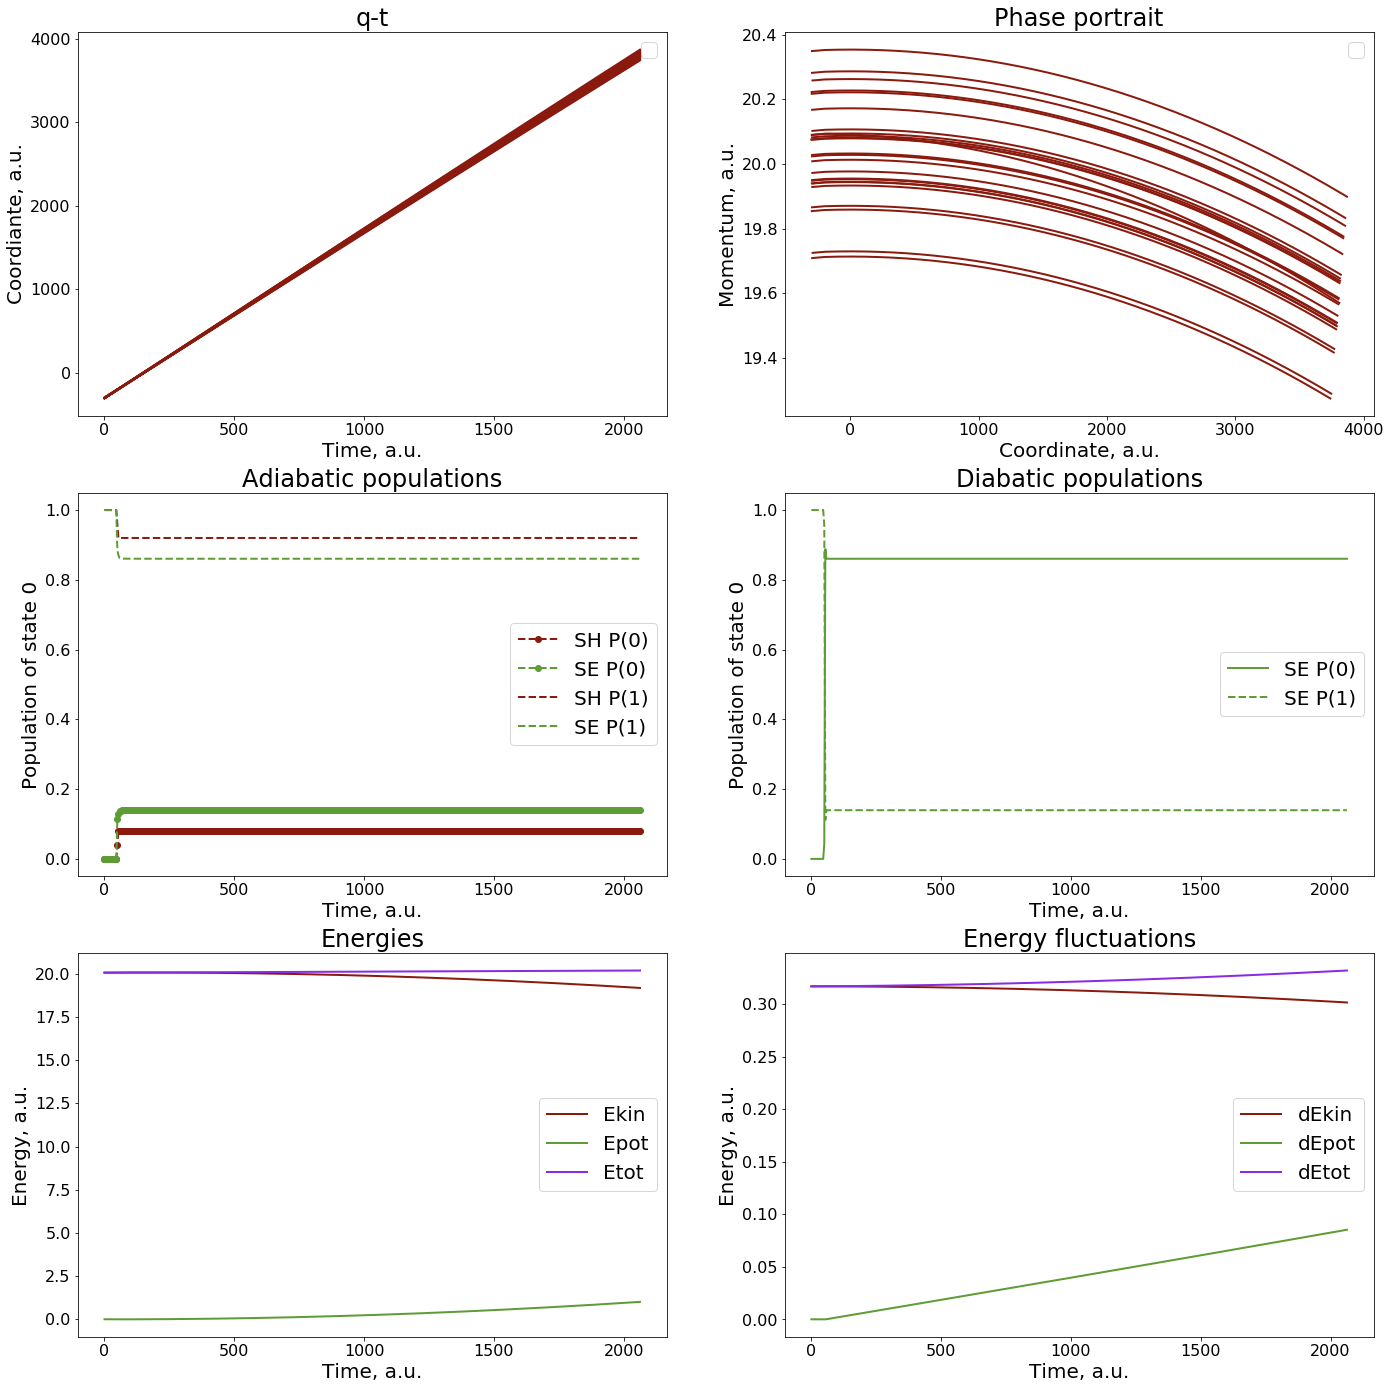

In [16]:
_init_elec = { "init_type":3, "nstates":2, "istates":[0.0, 1.0], "rep":1,  "ntraj":ntraj   }

_dyn_params = dict(dyn_params)    
_dyn_params.update({"rep_ham":0, "force_method":1, "rep_force":1, "rep_tdse":1, 
                    "nac_update_method":1, "tsh_method":0, "vel_rescale_opt":0})
_dyn_params.update({"prefix":"T3-1-4", "output_level":2, "file_output_level":3})

DR = MATRIX(2,2)
DR.set(0, 1, 1.0)
DR.set(1, 0, 1.0)
_dyn_params.update({"decoherence_algo":0, "decoh_rates":DR})

_model_params = {"model":1, "model0":1}    
res = dynamics.generic_recipe(q, p, iM, _dyn_params, compute_model, _model_params, _init_elec, rnd)
plot_dyn(res)

<a name="nbra-fssh"></a>
[Back to TOC](#TOC)

### 4.2. NBRA-FSSH dynamics

These runs use the vibronic Hamiltonians already precomputed along some trajectories (see the variety of approaches above to do this). So, in this case we do not really need a lot of calculations.

Some parameters that will be commonly used are:

* ``"rep_ham":1`` - we will assume that the compute model function will return object with the adiabatic properties (in fact, we need only the vibronic Hamiltonian, but it is still in the adiabatic representation)

* ``"force_method":0`` - to not call the calculation of forces at all.  

    **Note:** 
      Although all the forces will be zero, the fact that the initial nuclear momenta were not zero means the coordinates will change linearly in time (ballistic motion). However, these coordinates (plotted in this section) are meaningless, since the actual nuclear dynamics does not depend on electronic transitions. Instead, one should be looking at the trajectories along which the vibronic Hamiltonians are produced.

* ``"nac_update_method":0`` - we don't really have info about the derivative couplings here, so we can't compute time-NACs this way. In addition, since we'll be reading vibronic Hamiltonians directly, we don't want them being overwritten by such updating.

* ``"tsh_method":0`` - we are doing FSSH

* ``"vel_rescale_opt":-1`` - we don't need to rescale velocities since they don't affect anything

* ``"file_output_level":-1`` - unless we want to make sure we print out what we read, we don't really need the file output.

**IMPORTANT:**

In the ``model_params``, we should select:
* ``"model":3`` - to call the appropriate version of the function to "compute" Hamiltonians.
* ``"prefix"`` - need to point to the files that contain the corresponding properties (see the runs above)


In [17]:
_init_elec = { "init_type":3, "nstates":2, "istates":[0.0, 1.0], "rep":1,  "ntraj":ntraj   }

nbra_fssh_dyn_params = dict(dyn_params)
nbra_fssh_dyn_params.update({"rep_ham":1, "force_method":0, "rep_force":1, "rep_tdse":1, 
                             "nac_update_method":0, "tsh_method":0, "vel_rescale_opt":-1})
nbra_fssh_dyn_params.update({"output_level":2, "file_output_level":-1})

The calculation types differ just by the origin of the data used

<a name="nbra-fssh-1"></a>
[Back to TOC](#TOC)

### 4.2.1. NBRA-FSSH dynamics along the ground state PES

No handles with labels found to put in legend.
No handles with labels found to put in legend.


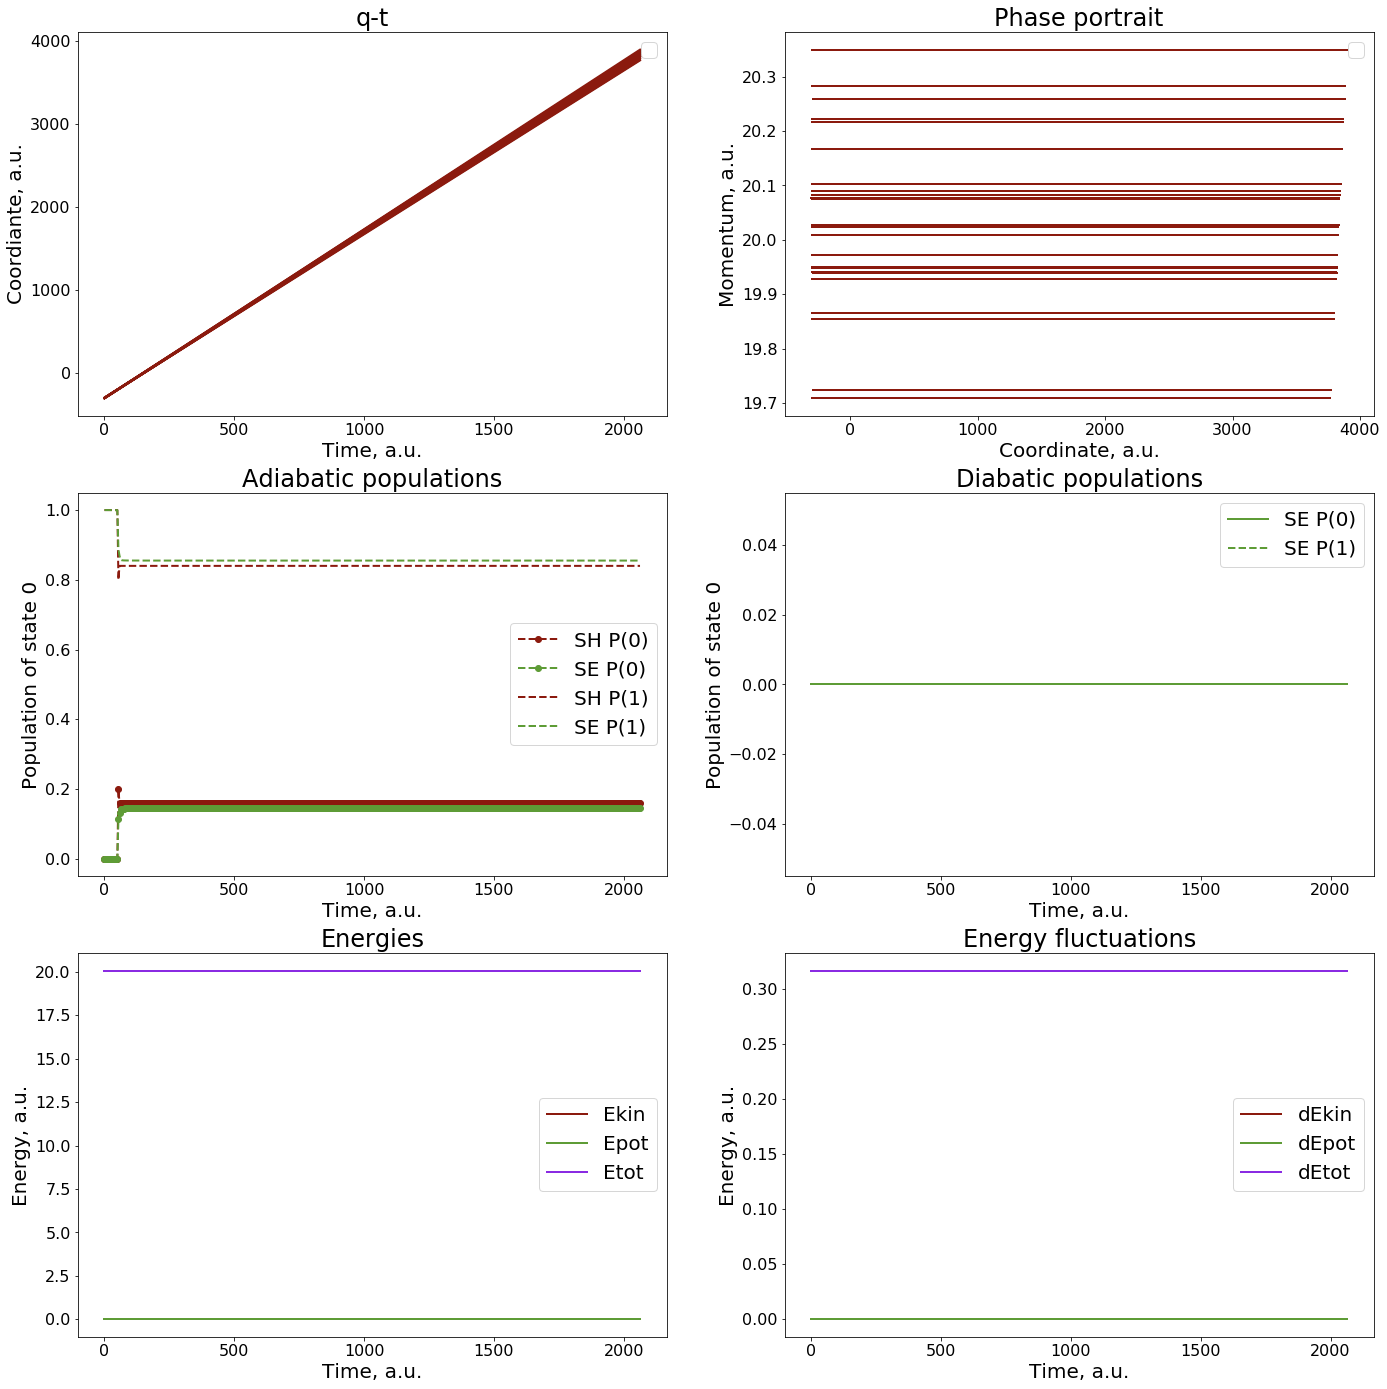

In [18]:
_dyn_params = dict(nbra_fssh_dyn_params)    

_dyn_params.update({"prefix":"T3-2-1"})
_model_params = {"model":3, "model0":3, "prefix":"T3-1-1/Hvib_adi_"}

res = dynamics.generic_recipe(q, p, iM, _dyn_params, compute_model, _model_params, _init_elec, rnd)
plot_dyn(res)

<a name="nbra-fssh-2"></a>
[Back to TOC](#TOC)

### 4.2.2. NBRA-FSSH dynamics along the excited state PES

No handles with labels found to put in legend.
No handles with labels found to put in legend.


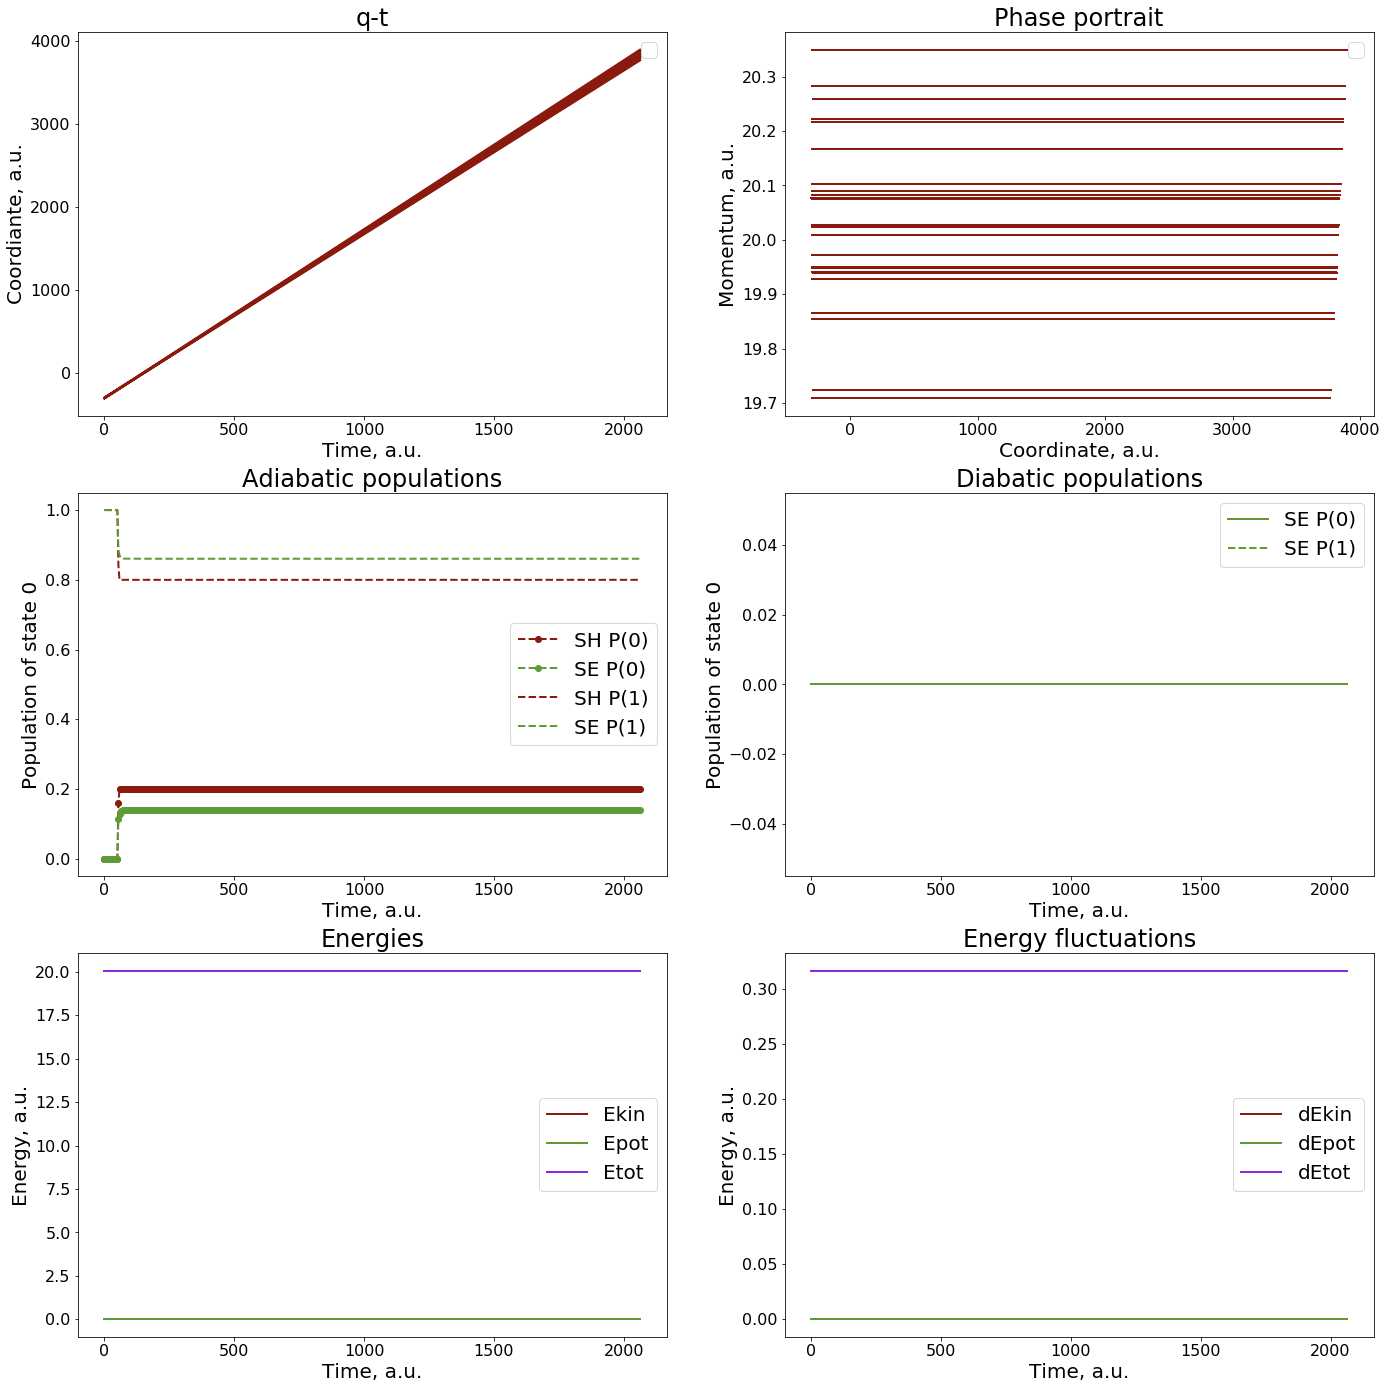

In [19]:
_dyn_params = dict(nbra_fssh_dyn_params)    

_dyn_params.update({"prefix":"T3-2-2"})
_model_params = {"model":3, "model0":3, "prefix":"T3-1-2/Hvib_adi_"}

res = dynamics.generic_recipe(q, p, iM, _dyn_params, compute_model, _model_params, _init_elec, rnd)
plot_dyn(res)

<a name="nbra-fssh-3"></a>
[Back to TOC](#TOC)

### 4.2.3. NBRA-FSSH dynamics along FSSH trajectories

No handles with labels found to put in legend.
No handles with labels found to put in legend.


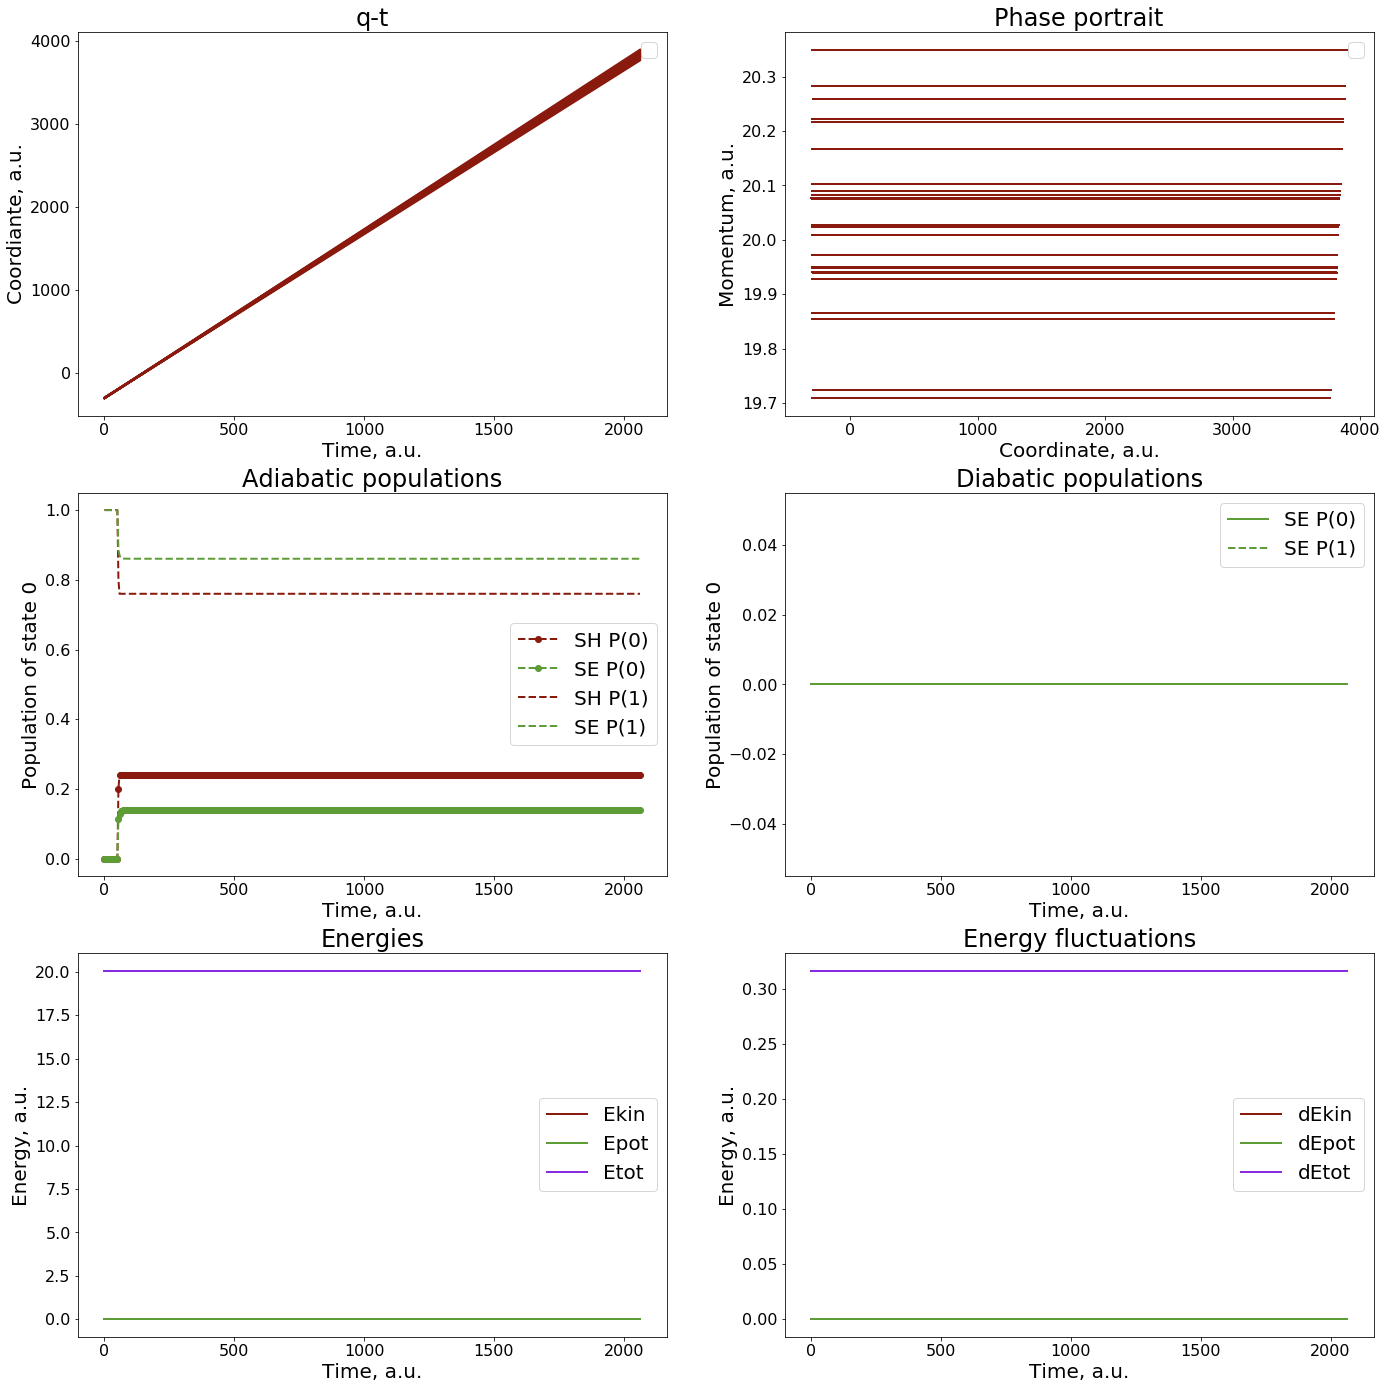

In [20]:
_dyn_params = dict(nbra_fssh_dyn_params)    

_dyn_params.update({"prefix":"T3-2-3"})
_model_params = {"model":3, "model0":3, "prefix":"T3-1-3/Hvib_adi_"}

res = dynamics.generic_recipe(q, p, iM, _dyn_params, compute_model, _model_params, _init_elec, rnd)
plot_dyn(res)

<a name="nbra-fssh-4"></a>
[Back to TOC](#TOC)

### 4.2.4. NBRA-FSSH dynamics along mSDM trajectories

No handles with labels found to put in legend.
No handles with labels found to put in legend.


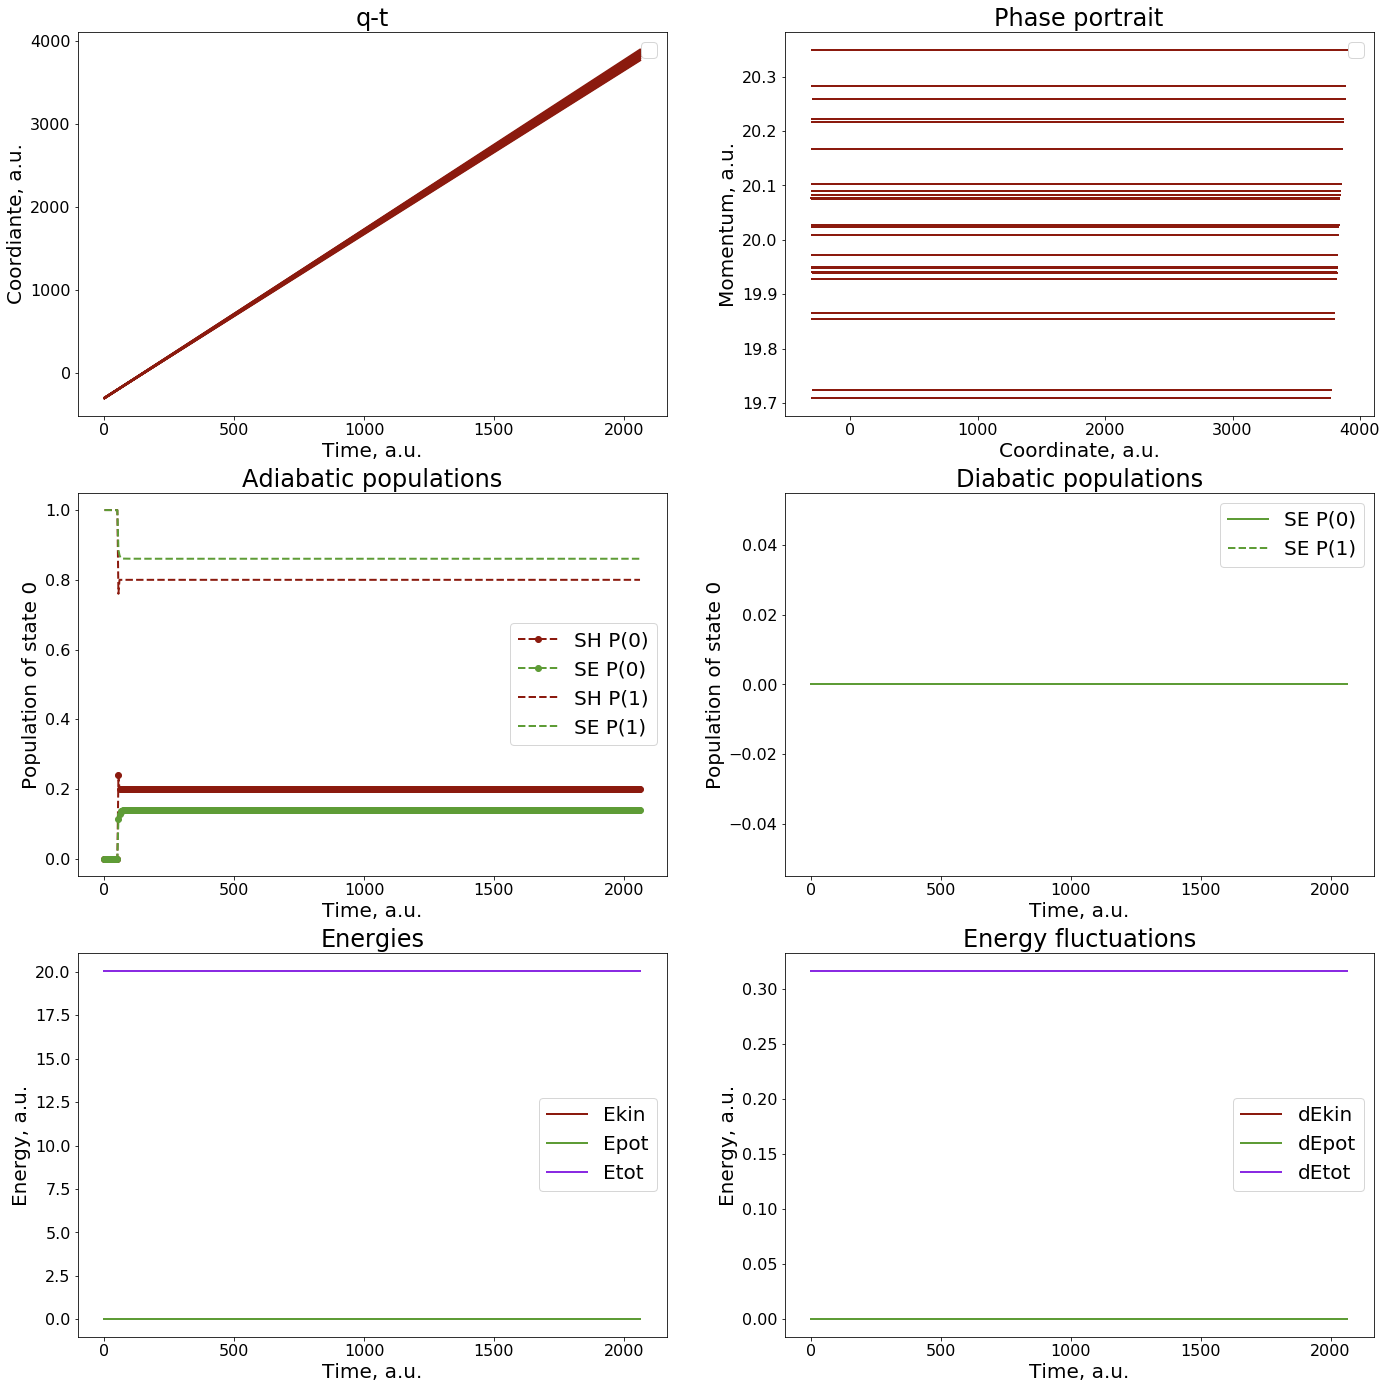

In [21]:
_dyn_params = dict(nbra_fssh_dyn_params)    

_dyn_params.update({"prefix":"T3-2-4"})
_model_params = {"model":3, "model0":3, "prefix":"T3-1-4/Hvib_adi_"}

res = dynamics.generic_recipe(q, p, iM, _dyn_params, compute_model, _model_params, _init_elec, rnd)
plot_dyn(res)